In [543]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

import re
import copy

In [544]:
# Loading and slightly modifying some parts of the data 

data = pd.read_csv('unlocks_data.csv')
df = data.drop(['Matched Study ID'], axis = 1)
df = df.dropna(subset = ['Study'])

combs = ['EDC and SDTM', 'EDC, SDTM']
df.loc[df.loc[:, 'Unlocked Source'].isin(combs) , 'Unlocked Source'] = 'Combination'

### Data Processing

In [545]:
cols_of_interest = ['TAU/BU', 'CRO', 'Type', 'Operating model', 'Unlocked Source']

In [546]:
conversion_dict = {'TAU/BU': {'ONC':['Onc Late', 'Onc Early', 'ONC', 'Early Onc'],
                              'NS': ['Neuro'],
                              'RGH': ['Rare', 'RGH'], 
                              'GI': ['GI'],
                              'Non Core':['VBU', 'ECD', 'GMA', 'PDT']},
                   'CRO': {'PRA': ['PRA', 'PRA EDS', 'PRA RWS', 'PRA PR', 'PRA '], 
                           'IQVIA': ['IQVIA'],
                           'Other':['Celerion', 'PeachTree']},
                   'Type': {'IA': ['IA', 'Interim'], 
                            'Final': ['Final']},
                   'Operating model': {'TOP': ['TOP'], 
                                       'TDOM': ['TDOM 1.0', 'TDOM 2.0', 'TDOM'], 
                                       'TTDOM': ['TTDOM', 'TTDOM (previously CTOM)', 'CTOM'],
                                       'Celerion': ['Celerion']},
                   'Unlocked Source': {'EDC': ['EDC'],
                                       'SDTM': ['SDTM', 'CTMS and SDTM', 'CTMS and SDTM ', 
                                                'SDTM ', 'SDTM  ', 'SDTM, Protocol deviations'],
                                       'Combination': ['EDC and SDTM', 'EDC, SDTM'],
                                       'Third Party': ['Third party data']},
                   'Process': {'SDTM': r'SDTM',
                               'Data Cleaning': r'leaning|Review',
                               'Third Party': r'Third|3rd|arty|IRT',
                               'Monitoring': r'onitoring'}
                  }

In [547]:
def convert_val(x, col, conversions):
    
    vals = [item for sublist in list(conversions.values()) for item in sublist]

    if col != 'Process':
        if x in vals:
            for key in conversions.keys():
                if x in conversions[key]:
                    return key
        elif x not in vals:
            return x

In [548]:
for col in cols_of_interest:
    conversions = conversion_dict[col]
    df.loc[:, col] = df.loc[:, col].apply(lambda x: convert_val(x, col, conversions))

In [549]:
process_vals = conversion_dict['Process']

for key in process_vals:
    series =  df.Process.str.contains(process_vals[key]).dropna()
    
    idxs = series.index
    truth_idx =  np.where(series)[0]
    idx_to_change = idxs[truth_idx]
    
    df.loc[idx_to_change, 'Process'] = key


In [550]:
def change_process(x):
    val_list = list(process_vals.keys())
    if x not in val_list:
        return 'Other'
    elif x in val_list:
        return x

df.Process = df.Process.apply(lambda x: change_process(x))

In [551]:
df.Process.value_counts()

Data Cleaning    23
SDTM             18
Other             9
Third Party       4
Monitoring        3
Name: Process, dtype: int64

In [574]:
df['date'] = pd.to_datetime(df['Unlock Date'])
df = df[df['date'].notna()]
df['year'] = pd.DatetimeIndex(df['date']).year.astype(int)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Plotting Functions

In [567]:
def set_plot_style():
    plt.figure(figsize = (10,8))
    sns.set(font_scale=1)
    sns.set_style("ticks")

    pass

def generate_plot_features(xaxis_title, yaxis_title, title):
    #plt.title(f'{title}')
    plt.xlabel(f'{xaxis_title}')
    plt.ylabel(f'{yaxis_title}')
    
    pass

In [522]:
label_dict = {'TAU/BU': ['ONC', 'GI', 'NS', 'RGH', 'Non Core'],
              'CRO': ['PRA', 'PPD', 'IQVIA', 'Other'],
              'Type': ['IA', 'Final'],
              'Operating model': ['TDOM', 'TOP', 'TTDOM', 'Celerion'],
              'Unlocked Source': ['SDTM', 'EDC', 'Combination', 'Third Party'],
              'Process': ['Data Cleaning', 'SDTM', 'Third Party', 'Monitoring', 'Other']}

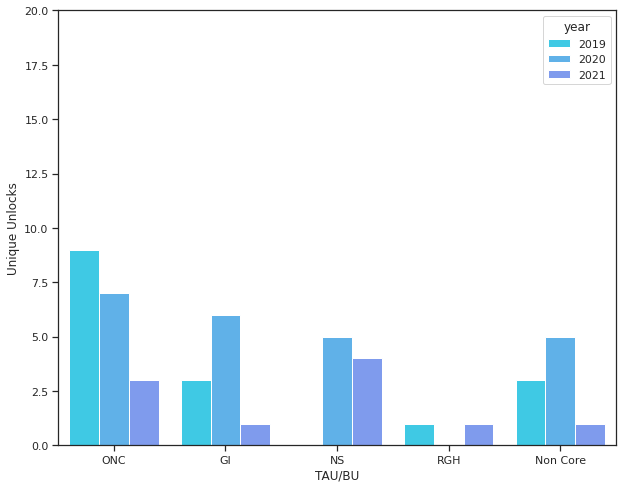

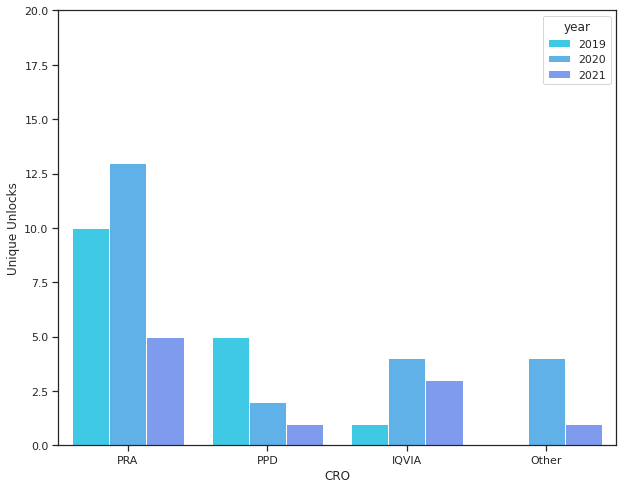

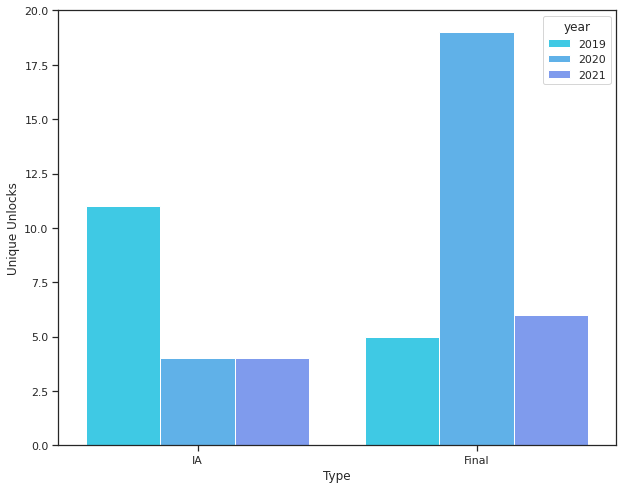

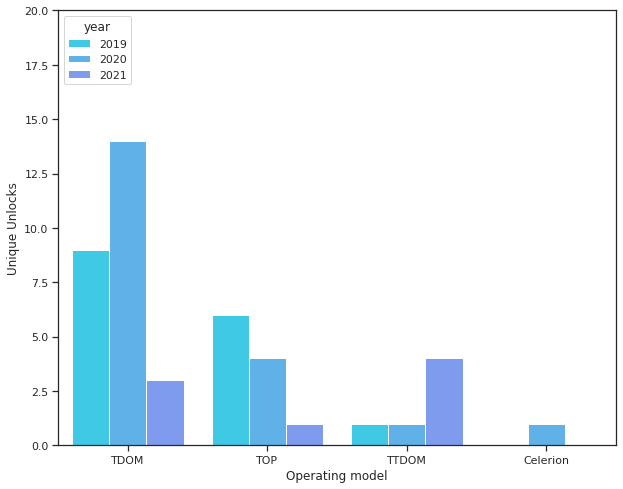

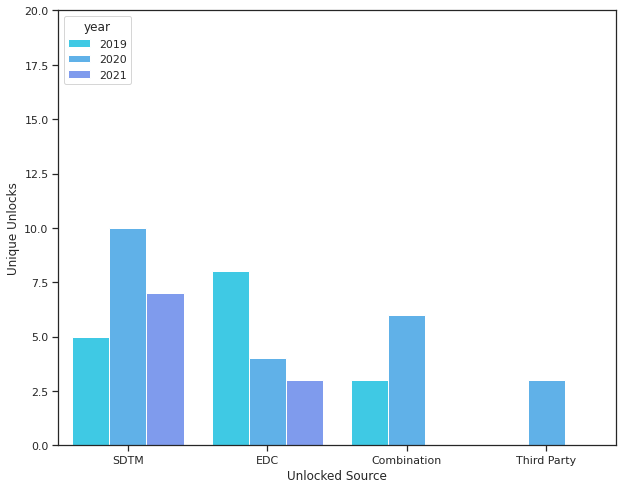

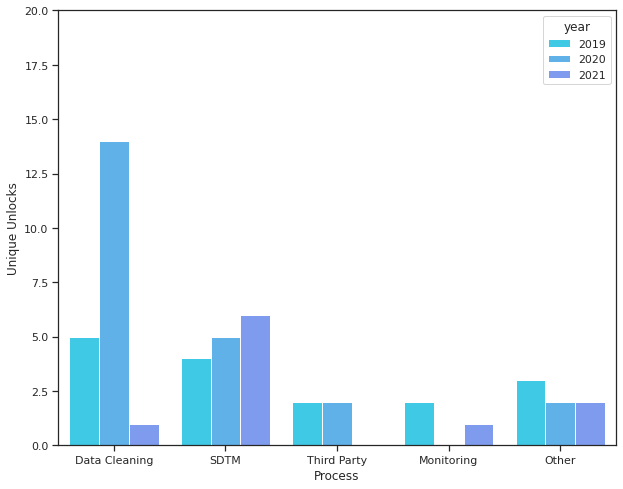

In [576]:
cols = ['TAU/BU', 'CRO', 'Type', 'Operating model', 'Unlocked Source', 'Process']
for col in cols:
    
    label_order = label_dict[col]
        
    set_plot_style()
    
    sns.set(font_scale=1)
    sns.set_style('ticks')
    sns.set_palette('cool')
    ax = sns.countplot(data = df, x = col, hue = 'year', order = label_order)
    ax.set(ylim=(0, 20))
    generate_plot_features(xaxis_title = col, yaxis_title = 'Unique Unlocks', title = f'Unlocks by {col}')
    plt.savefig(f'{col[:3]}_counts.png')
    plt.show()

In [577]:
#df.to_csv('processed_DBUL_data_prevalence.csv')